In [1]:
import numpy as np
import pandas as pd

In [2]:
class PCA:
    def __init__(self, n_components=None, whiten=False):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.whiten = whiten
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        idx = eigenvalues.argsort()[::-1]
        eigenvectors = eigenvectors[:, idx]
        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components]
            self.explained_variance_ = eigenvalues[idx][:self.n_components]
        else:
            self.components = eigenvectors
            self.explained_variance_ = eigenvalues[idx]
        self.explained_variance_ratio_ = self.explained_variance_ / np.sum(eigenvalues)
        
    def transform(self, X):
        X_centered = X - self.mean
        transformed = np.dot(X_centered, self.components)
        if self.whiten:
            transformed /= np.sqrt(self.explained_variance_)
        return transformed
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X):
        if self.whiten:
            X = X * np.sqrt(self.explained_variance_)
        return np.dot(X, self.components.T) + self.mean



# Data preprocessing

In [3]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [5]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [18]:
dirpath = '/Users/aaryansharma/Downloads/SMAI-Dataset-release/IIIT-CFW'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


### Data Description

#### `X` array
`X` is the dataset, a numpy array of shape `(N, H, W, C)`, where `N` is the number of images, `H` is the height of the image, `W` is the width of the image, and `C` is the number of channels in the image.

#### `y` array
`y` is a numpy array of shape `(N,)`, where `N` is the number of images. It contains the labels of the images.

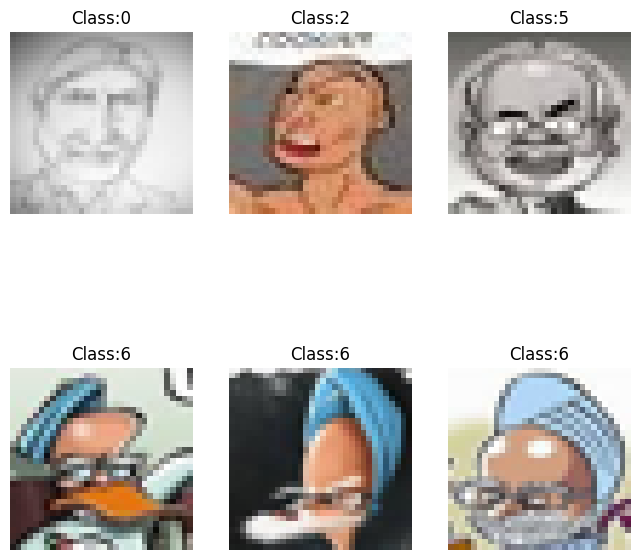

In [7]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [8]:
print(X.shape)
reshape_example = X.reshape(X.shape[0],-1)
print(X.shape[0])
print(reshape_example.shape)

(672, 32, 32, 3)
672
(672, 3072)


In [10]:
import matplotlib.pyplot as plt

X_reshaped = X.reshape(X.shape[0], -1)
# Calculating pca for different values of n_components
n_components = [2, 5, 10, 20, 50, 100, 200, 300, 400, 500]
cumulative_explained_variance = []
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit_transform(X_reshaped)
    cumulative_explained_variance.append(np.sum(pca.explained_variance_ratio_))
    
    # For debugging

    # print(f"n_components={n}")
    # print(f"Explained Variance: {pca.explained_variance_}")
    # print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
    # print(f"Sum of Explained Variance: {np.sum(pca.explained_variance_)}")
    # print(f"Sum of Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_)}")


[0.41963403121815196, 0.5303459484363451, 0.619941031875522, 0.7028868452521294, 0.8110605249678828, 0.8860128603333128, 0.949395257669951, 0.9766740993029757, 0.9899538257700424, 0.9964192834424589]


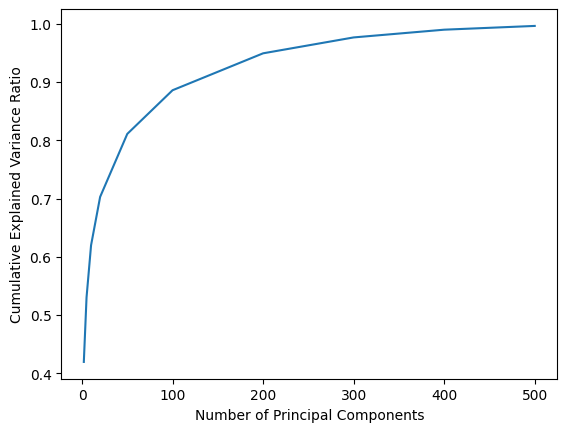

In [11]:
# Plot the relationship between the cumulative explained variance and the number of principal components
print(cumulative_explained_variance)
plt.plot(n_components, cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


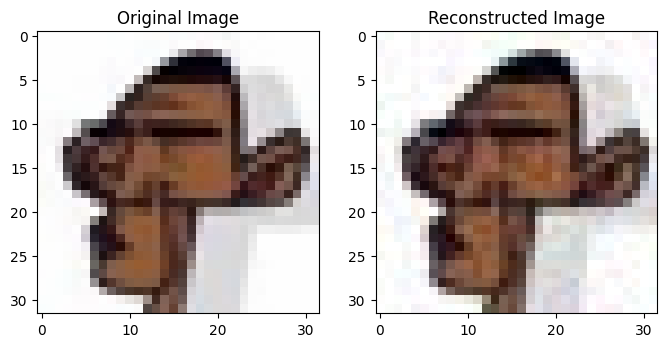

In [12]:
# create an instance of PCA with n_components=400
pca = PCA(n_components=400)

# fit the PCA instance on X
pca.fit(X_reshaped)

# choose a random image from X
random_image_index = np.random.randint(X.shape[0])
random_image = X[random_image_index]

# transform the chosen image using the fitted PCA instance
transformed_image = pca.transform(X_reshaped[random_image_index].reshape(1, -1))

# inverse transform the transformed image using the fitted PCA instance
reconstructed_image = pca.inverse_transform(transformed_image)

# display the original and the reconstructed image
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(random_image)
ax[0].set_title('Original Image')
ax[1].imshow(reconstructed_image.reshape(H, W, C))
ax[1].set_title('Reconstructed Image')
plt.show()


### PCA on Assignment-1 Dataset



In [9]:
data = np.load('/Users/aaryansharma/Downloads/data.npy', allow_pickle=True)

In [10]:
print(data.shape)

(1500, 5)


In [11]:
print(data[:, 1][0].shape)

(1, 1024)


In [12]:
vit_embeddings = data[:, 1]
resnet_embeddings = data[:, 2]

print(vit_embeddings.shape)
print(resnet_embeddings.shape)

(1500,)
(1500,)


In [13]:
z =data[:, 2]
vit = []
for array in z:
    vit.append(array)

vit = np.array(vit)
vit = vit[:, 0, :]
vit[0]

array([ 3.10947031e-01,  2.02134550e-01, -1.65195927e-01, -5.30651547e-02,
        5.23523875e-02, -1.09312914e-01,  9.50801000e-02,  5.46784282e-01,
        1.77887410e-01, -1.29239470e-01,  4.41051833e-02,  1.62483811e-01,
        5.05538166e-01, -1.81502864e-01, -3.72953643e-03,  2.05922946e-01,
       -3.28672454e-02,  2.36101121e-01, -1.93321794e-01, -3.24127674e-02,
       -2.34914303e-01,  9.93825719e-02,  2.38913178e-01,  1.11546433e-02,
       -1.03153531e-02,  2.39208445e-01, -5.91072798e-01, -2.42058225e-02,
        2.03015730e-01, -3.03352922e-01,  3.71672064e-01,  3.66571993e-01,
        1.68978393e-01,  5.01465261e-01,  5.81834614e-02, -8.25178474e-02,
       -1.68615520e-01, -1.74425364e-01, -2.88018227e-01, -1.26360071e+00,
       -1.94235846e-01, -2.02687792e-02,  3.90713550e-02, -2.13049755e-01,
        2.82879591e-01,  4.54546094e-01,  1.24902450e-01,  1.13772079e-01,
       -3.50662977e-01, -3.35117251e-01,  5.50046489e-02, -1.99079067e-01,
        2.65548110e-01, -

In [14]:
print(vit.shape)

(1500, 512)


In [15]:
it = data[:, 1]
print(it.shape)

resnet = []

for array in it:
    resnet.append(array)

resnet = np.array(resnet)
resnet = resnet[:, 0, :]
resnet.shape

(1500,)


(1500, 1024)

In [20]:
n_components = [2, 5, 10, 20, 50, 100, 200, 300, 350]
cumulative_explained_variance_vit = []
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit_transform(vit)
    cumulative_explained_variance_vit.append(np.sum(pca.explained_variance_ratio_))


[0.1796865865603371, 0.3043130934258055, 0.4365705511795902, 0.5738763721917375, 0.7460278360165725, 0.8597620960233533, 0.9480894880924076, 0.981061717272222, 0.9894148241642797]


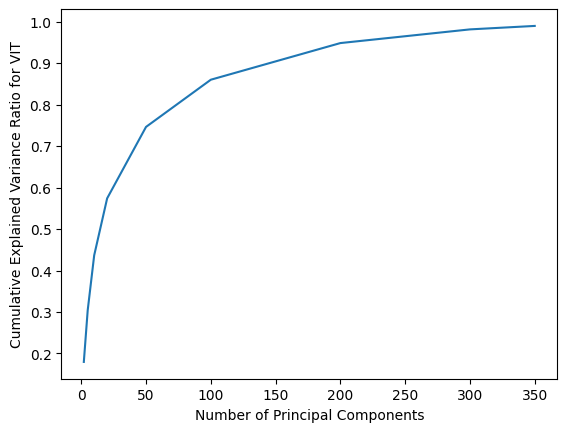

In [21]:
print(cumulative_explained_variance_vit)
plt.plot(n_components, cumulative_explained_variance_vit)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio for VIT')
plt.show()

In [22]:
n_components = [2, 5, 10, 20, 50, 100, 200, 300, 350]
cumulative_explained_variance_resnet = []
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit_transform(resnet)
    cumulative_explained_variance_resnet.append(np.sum(pca.explained_variance_ratio_))

[0.22969768266480617, 0.36589530642913354, 0.4921721039312988, 0.6343525551125077, 0.79465064078042, 0.8901258181841479, 0.9596063310997182, 0.9844417241277659, 0.9906398366567826]


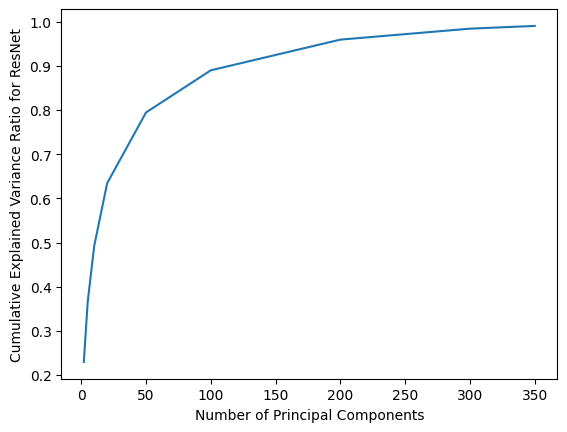

In [23]:
print(cumulative_explained_variance_resnet)
plt.plot(n_components, cumulative_explained_variance_resnet)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio for ResNet')
plt.show()

### Metric Reporting

In [24]:
# For ResNet embeddings

# create an instance of PCA with n_components=350

pca = PCA(n_components=350)

# fit the PCA instance on X
resnet_transformed = pca.fit_transform(resnet)

resnet_transformed.shape


(1500, 350)

In [25]:
# For VIT embeddings

pca = PCA(n_components=350)

# fit the PCA instance on X
vit_transformed = pca.fit_transform(vit)

vit_transformed.shape

(1500, 350)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter
from icecream import ic
ic.disable()

In [29]:
# Predicting data using KNN
class KNN:
    def __init__(self, k=3, metric_type='euclidean', encoder_type='vit'):
        self.k = k
        self.metric_type = metric_type
        self.encoder_type = encoder_type

    def fit(self, X_resnet, X_vit, y_resnet, y_vit):
        ic(X_resnet.shape, X_vit.shape, y_resnet.shape, y_vit.shape)
        if self.encoder_type == 'resnet':
            self.X_train = X_resnet
            self.y_train = y_resnet
        elif self.encoder_type == 'vit':
            self.X_train = X_vit
            self.y_train = y_vit
        self.X_train = StandardScaler().fit_transform(self.X_train)
        
    def predict(self, X):
        predictions = [self.predict_helper(x) for x in X]
        return np.array(predictions)
    
    def predict_helper(self, x):
        # compute the distances
        # check dimensionality of x, x_train
        ic(x.shape)
        ic(self.X_train.shape)
        ic(self.encoder_type)
        distances = [self.distance_metric(x, x_train) for x_train in self.X_train]
        if None in distances:
            print(distances)
            raise ValueError("None value in distances")
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # return the most common label
        most_common = Counter(k_nearest_labels).most_common()
        return most_common[0][0]
    
    def distance_metric(self, x1, x2):
        if self.metric_type == 'euclidean':
            return np.linalg.norm(x1 - x2)
        elif self.metric_type == 'manhattan':
            ic(x1.shape)
            ic(x2.shape)
            return np.sum(np.abs(x1 - x2))
        elif self.metric_type == 'cosine':
            x1 = np.squeeze(x1)
            x2 = np.squeeze(x2)
            return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
    
    def score(self, X_val_resnet, X_val_vit, y_val_resnet, y_val_vit):
            # if self.encoder_type == 'resnet':
            #     X = X[:, 0]
            # elif self.encoder_type == 'vit':
            #     X = X[:, 1]
        # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        # self.fit(X_train, y_train)
        X_val_resnet = StandardScaler().fit_transform(X_val_resnet)
        X_val_vit = StandardScaler().fit_transform(X_val_vit)
        if self.encoder_type == 'resnet':
            y_pred = self.predict(X_val_resnet)
            y = y_val_resnet
        elif self.encoder_type == 'vit':
            y_pred = self.predict(X_val_vit)
            y = y_val_vit

        # y_pred = self.predict(X)  
        f1 = f1_score(y, y_pred, average='macro')
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='macro', zero_division=1)
        recall = recall_score(y, y_pred, average='macro', zero_division=1)
        return f1, accuracy, precision, recall

In [30]:
# Split data into train and validation set
X_train_vit_transformed, X_val_vit_transformed, y_train_vit_transformed, y_val_vit_transformed = train_test_split(vit_transformed, data[:, 3], test_size=0.2)
X_train_resnet_transformed, X_val_resnet_transformed, y_train_resnet_transformed, y_val_resnet_transformed = train_test_split(resnet_transformed, data[:, 3], test_size=0.2)
print(X_train_resnet_transformed.shape, X_val_resnet_transformed.shape, y_train_resnet_transformed.shape, y_val_resnet_transformed.shape)
print(X_train_vit_transformed.shape, X_val_vit_transformed.shape, y_train_vit_transformed.shape, y_val_vit_transformed.shape)

(1200, 350) (300, 350) (1200,) (300,)
(1200, 350) (300, 350) (1200,) (300,)


In [31]:
encoding_type = ['vit', 'resnet']
metric_type = ['manhattan', 'euclidean', 'cosine']
results = []
for encoding in encoding_type:
    for metric in metric_type:
        for k in range(1, 39):
            knn_model = KNN(k=k, metric_type=metric, encoder_type=encoding)
            knn_model.fit(X_train_resnet_transformed, X_train_vit_transformed, y_train_resnet_transformed, y_train_vit_transformed)
            f1, accuracy, precision, recall = knn_model.score(X_val_resnet_transformed, X_val_vit_transformed, y_val_resnet_transformed, y_val_vit_transformed)
            results.append([encoding, metric, k, f1, accuracy, precision, recall])

In [33]:
results = np.array(results)
# print(results)
print(results.shape)

sorted_indices = np.argsort(results[:, 4])[::-1]

# Keep only the top 20 rows
top_20_results = results[sorted_indices[:20]]
for i in range(top_20_results.shape[0]):
    print( "Rank: ", i+1, "  ")
    print("Encoding: ", top_20_results[i, 0], "  ")
    print("Metric: ", top_20_results[i, 1], "  ")
    print("K: ", top_20_results[i, 2], "  ")
    print("F1: ", top_20_results[i, 3], "  ")
    print("Accuracy: ", top_20_results[i, 4], "  ")
    print("Precision: ", top_20_results[i, 5], "  ")
    print("Recall: ", top_20_results[i, 6], "  ")
    print("--------------------------------------")

(228, 7)
Rank:  1   
Encoding:  vit   
Metric:  cosine   
K:  9   
F1:  0.1954180922907654   
Accuracy:  0.31   
Precision:  0.45830068314245537   
Recall:  0.3477144866385372   
--------------------------------------
Rank:  2   
Encoding:  vit   
Metric:  cosine   
K:  11   
F1:  0.19823749026237714   
Accuracy:  0.30666666666666664   
Precision:  0.4625279812779813   
Recall:  0.3334757834757835   
--------------------------------------
Rank:  3   
Encoding:  vit   
Metric:  cosine   
K:  10   
F1:  0.18592208753141048   
Accuracy:  0.30333333333333334   
Precision:  0.44924378556454025   
Recall:  0.34426974143955275   
--------------------------------------
Rank:  4   
Encoding:  vit   
Metric:  cosine   
K:  12   
F1:  0.19062988034525033   
Accuracy:  0.3   
Precision:  0.4699948796722991   
Recall:  0.3194982078853047   
--------------------------------------
Rank:  5   
Encoding:  vit   
Metric:  cosine   
K:  5   
F1:  0.19577117857372633   
Accuracy:  0.2966666666666667   
Pr

In [ ]:
import matplotlib.pyplot as plt

X_reshaped = X.reshape(X.shape[0], -1)
# Calculating pca for different values of n_components
n_components = 50
pca_dataset = []
cumulative_explained_variance = []
for n in range(1, n_components+1):
    pca = PCA(n_components=n)
    pca.fit_transform(X_reshaped)
    pca_dataset.append(pca.transform(X_reshaped))
    cumulative_explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Predicting pca_dataset using KNN

# Split data into train and validation set
    

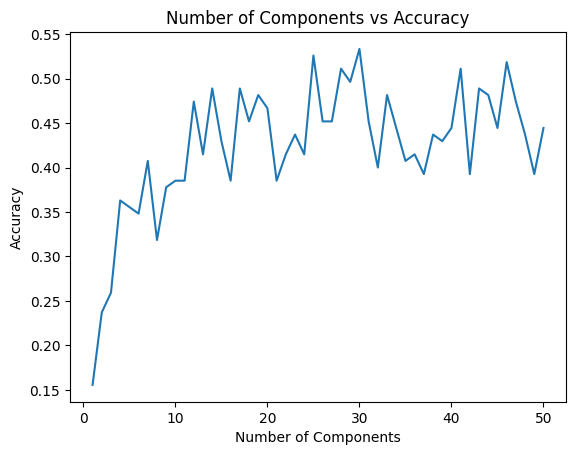

In [31]:
results = []

from sklearn.neighbors import KNeighborsClassifier

for pca_data in pca_dataset:
    X_train, X_val, y_train, y_val = train_test_split(pca_data, y, test_size=0.2)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    knn_model.fit(X_train, y_train)
    accuracy = knn_model.score(X_val, y_val)
    # print(y_pred.shape, y.shape)
    # accuracy = accuracy_score(y, y_pred)
    results.append(accuracy)

# Plotting the graph
plt.plot(range(1, n_components+1), results)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Number of Components vs Accuracy')
plt.show()


We observe that as we increase the number of components, the accuracy increases. This is because we are able to capture more variance in the data. However, we also observe that the accuracy saturates after a certain number of components. This is because the components after that do not contribute much to the variance in the data.

### PCA 2.2

In [32]:
drawer_df = pd.read_csv('/Users/aaryansharma/Downloads/smai_assignment_pictionary/drawer_attributes.csv')
guess_df = pd.read_csv('/Users/aaryansharma/Downloads/smai_assignment_pictionary/guesser_attributes.csv')

In [33]:
drawer_df.head()

,d_drawer,d_area_median,d_stroke_freq_median,d_rangestroketime_median,d_firststroketime_median,d_laststroketime_median,d_pcgamestup,d_pcgamestdown,d_pcgameserasehighlight
0,10,0.000000,0.000000,0.000,0.000,0.000,0.00,0.0,0.000000
1,36,82306.749763,0.578802,21.660,3.512,26.815,0.00,0.0,0.777778
2,14,60929.328432,0.239168,25.087,1.368,26.455,1.00,1.0,1.000000
3,26,119037.637976,0.402533,54.162,2.459,56.621,0.75,0.5,1.000000
4,40,0.000000,0.000000,0.000,0.000,0.000,0.00,0.0,0.000000


In [34]:
guess_df.head()

,g_guesser,g_noofmessage_median,g_firstmessagetime_median,g_lastmessagetime_median,g_rangemessagetime_median,g_pcgamesconfusion,g_entropy
0,10,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,36,1.0,25.367172,39.041594,0.000000,0.0,0.000000
2,14,2.0,12.988740,51.351317,38.362577,1.0,0.693147
3,26,3.5,20.622346,64.718058,44.095712,0.0,1.242453
4,40,3.0,30.339558,78.943003,48.603445,0.0,1.098612


In [35]:
# Convert the drawer_df to a numpy array
drawer = drawer_df.to_numpy()
drawer.shape

(100, 9)

In [36]:
# Convert the guess_df to a numpy array
guesser = guess_df.to_numpy()
guesser.shape

(100, 7)

In [37]:
# For n_components = 1 to 9, calculate the cumulative explained variance ratio for drawer and plot graph

drawer_cumulative_explained_variance = []

for n in range(1, 10):
    pca = PCA(n_components=n)
    pca.fit_transform(drawer)
    drawer_cumulative_explained_variance.append(np.sum(pca.explained_variance_ratio_))

[0.9999939892359285, 0.9999995636370994, 0.999999993270101, 0.999999998420515, 0.999999999928035, 0.9999999999752135, 0.9999999999861369, 0.9999999999934654, 1.0]


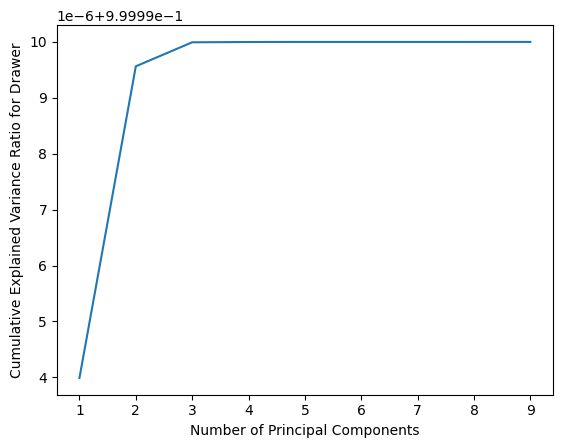

In [38]:
print(drawer_cumulative_explained_variance)
plt.plot(range(1, 10), drawer_cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio for Drawer')
plt.show()

(100, 2) (100, 2)


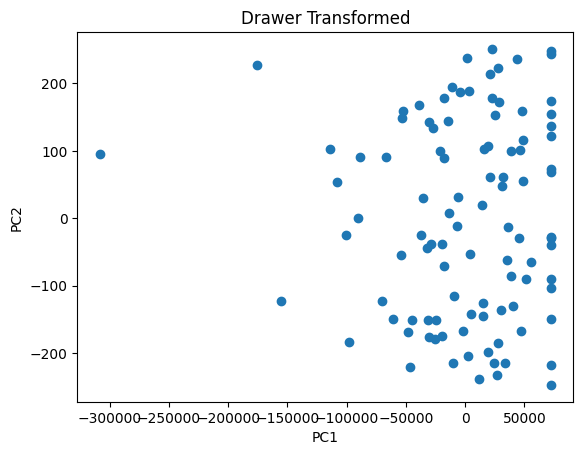

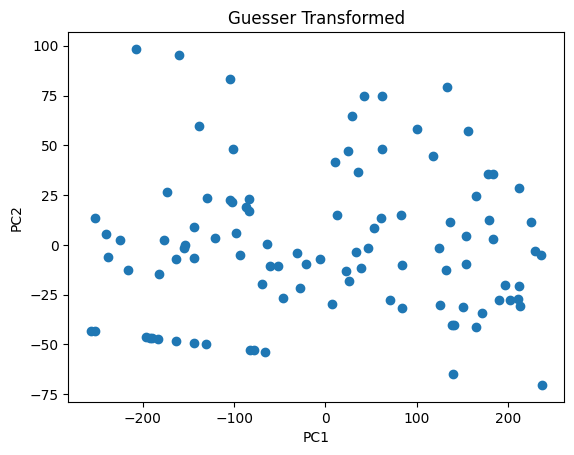

In [47]:
pca = PCA(n_components=2)

# fit the PCA instance on drawer

drawer_transformed = pca.fit_transform(drawer)

guesser_transformed = pca.fit_transform(guesser)

print(drawer_transformed.shape, guesser_transformed.shape)
# from IPython.display import display, HTML
# display(HTML(drawer_reconstructed_df.to_html()))
# display(HTML(drawer_df.to_html()))

import matplotlib.pyplot as plt

# plot for drawer_transformed
plt.scatter(drawer_transformed[:, 0], drawer_transformed[:, 1])
plt.title('Drawer Transformed')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# plot for guesser_transformed
plt.scatter(guesser_transformed[:, 0], guesser_transformed[:, 1])
plt.title('Guesser Transformed')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In PCA, the new axes represent the principal components of the data. The first principal component (PC1) represents the direction of maximum variance in the data. The second principal component (PC2) represents the direction of maximum variance in the data orthogonal to PC1. The remaining principal components represent the directions of maximum variance in the data orthogonal to the previous principal components. Each principal component is a linear combination of the original features of the data.

### Gaussian Mixture Models

In [34]:
gmm_data_path = '/Users/aaryansharma/Downloads/SMAI-Dataset-customer-dataset/data.csv'

In [4]:
gmm_data_df = pd.read_csv(gmm_data_path)
gmm_data_df.head()

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
gmm_data_df[['Age', 'Income']] = scaler.fit_transform(gmm_data_df[['Age', 'Income']])

In [6]:
gmm_data_df.

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,2.653614,2,0.097524,1,2
1,1,1,1,-1.187132,1,0.782654,1,2
2,2,0,0,1.117316,1,-0.833202,0,0
3,3,0,0,0.775916,1,1.328386,1,1
4,4,0,0,1.458716,1,0.736932,1,1


In [37]:
gmm_data = gmm_data_df.to_numpy()
gmm_data

NameError: name 'gmm_data_df' is not defined

In [36]:
cov = np.cov(gmm_data, rowvar=False)
print(np.round(cov, 2))
mean = np.mean(gmm_data, axis=0)
print(mean)

NameError: name 'gmm_data' is not defined

In [35]:
# Initialise the mean and covariance matrix
clusters = 3
dimensions = 7
# A = np.random.rand(dimensions, dimensions)
covar = np.zeros((clusters, dimensions, dimensions))
mean = mean
for i in range(clusters):
    # A = np.random.rand(dimensions, dimensions)
    covar[i] = cov  # make the matrix positive semi-definite
    print(np.round(covar[0], 2))

print('mean:', mean)
pi = np.ones(clusters) / clusters
# print(np.round(covar[0], 2))


NameError: name 'mean' is not defined

In [30]:
def sqrt_matrix(A):
    evalues, evectors = np.linalg.eigh(A)
    # Ensuring square root matrix exists
    assert (evalues >= 0).all()
    sq_matrix = evectors * np.sqrt(evalues) @ evectors.T
    return sq_matrix

In [33]:
print(gmm_data[0])
print(mean)

[0.         0.         0.         2.65361447 2.         0.09752361
 1.         2.        ]
[9.99500000e+02 4.57000000e-01 4.96500000e-01 9.05941988e-17
 1.03800000e+00 1.56319402e-16 8.10500000e-01 7.39000000e-01]


In [34]:
gmm_data.shape[0]

2000

In [12]:
responsibility = np.zeros((gmm_data.shape[0], clusters))
responsibility.shape

(2000, 3)

In [35]:
-0.5 * np.dot(np.dot((gmm_data[0] - mean[0]), np.linalg.inv(covar[0])), (gmm_data[0] - mean[0]).T)
# print(np.dot((gmm_data[0] - mean[0]), np.linalg.inv(covar[0])), (gmm_data[0] - mean[0]).T)

-6068639.728910232

In [1]:
def pseudo_determinant(A):
    evalues, evectors = np.linalg.eigh(A)
    return np.prod(evalues[evalues > 1e-15])

In [100]:
np.linalg.pinv(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
np.linalg.eigvals(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
eigenvals = np.linalg.eigvals(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
eigenvals[eigenvals < 1e-15] = 1
print(eigenvals)
determinant = np.prod(eigenvals)
determinant

[3. 1. 1.]


3.0

In [2]:
denominator = 0
for i in range(gmm_data.shape[0]):
    for c in range(clusters):
        for k in range(clusters):
            denominator += pi[k] * np.exp(-0.5 * np.dot(np.dot((gmm_data[i] - mean[k]).T, np.linalg.pinv(covar[k])), (gmm_data[i] - mean[k])))
        responsibility[i,c] = (pi[c] * (np.sqrt(1/pseudo_determinant(covar[c])))) * np.exp(-0.5 * np.dot(np.dot((gmm_data[i] - mean[c]).T, np.linalg.pinv(covar[c])), (gmm_data[i] - mean[c])))

print(responsibility.shape)
with np.printoptions(threshold=np.inf):
    print(responsibility)

NameError: name 'gmm_data' is not defined

In [112]:
# check if the sum of the responsibilities for each data point is 1
np.sum(responsibility, axis=1)

array([507607.43520923, 507607.52619144, 507607.60640408, ...,
       461438.23704927, 461274.35346936, 461393.34075795])

In [159]:
ex = np.array([[0.57474934, 0.72357269, 0.35033499],
               [0.72357269, 0.92541236, 0.49302715], 
               [0.35033499, 0.49302715, 0.54129317]])
evalues, evectors = np.linalg.eigh(ex)
# Ensuring square root matrix exists
assert (evalues >= 0).all()
sqrt_matrix = evectors * np.sqrt(evalues) @ evectors.T
print(sqrt_matrix)

print(np.dot(sqrt_matrix, sqrt_matrix))


[[0.49706031 0.54757888 0.16684651]
 [0.54757888 0.73644496 0.28847627]
 [0.16684651 0.28847627 0.65592443]]
[[0.57474934 0.72357269 0.35033499]
 [0.72357269 0.92541236 0.49302715]
 [0.35033499 0.49302715 0.54129317]]


In [108]:
for c in range(clusters):
    if not np.array_equal(responsibility[:, c], np.zeros(gmm_data.shape[0])):
        N = np.sum(responsibility[:,c])
        new_mean = np.zeros(dimensions)
        new_pi = N/gmm_data.shape[0]
        new_covar = np.zeros((dimensions, dimensions))
        for i in range(gmm_data.shape[0]):
            new_mean += (responsibility[i,c] * gmm_data[i])/N
        for i in range(gmm_data.shape[0]):
            new_covar += (responsibility[i,c] * np.dot((gmm_data[i] - new_mean), (gmm_data[i] - new_mean).T))/N
        covar[c] = new_covar
        mean = new_mean
        pi[c] = new_pi



In [ ]:
class GMM:
    